In [1]:
import numpy
import sympy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.viz import GraphicalModel
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json

In [2]:
p = lambda: Concept(name='p')  # protein
r = lambda: Concept(name='r')  # rna

t2 = NaturalDegradation(subject=r())
t2.set_mass_action_rate_law('V')
t3 = ControlledProduction(controller=r(), outcome=p())
t3.set_mass_action_rate_law('L')
t4 = NaturalDegradation(subject=p())
t4.set_mass_action_rate_law('U')

params = {'V': Parameter(name='V', value=0.03),
          'L': Parameter(name='L', value=2),
          'U': Parameter(name='U', value=0.15)}

initials = {
    'p': Initial(concept=p(), expression=sympy.Float(100)),
    'r': Initial(concept=r(), expression=sympy.Float(3))
}
    

tm = TemplateModel(
    templates=[t2, t3, t4],
    parameters=params,
    initials=initials
    )

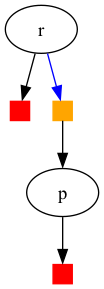

In [3]:
GraphicalModel.for_jupyter(tm)

In [4]:
chen_tm = stratify(tm,
                   key='species',
                   strata=['1', '2', '3'],
                   structure=[],
                   cartesian_control=False)

for i in range(1, 4):
    t = ControlledProduction(controller=Concept(name='p_1', context={'species': '1'}),
                             outcome=Concept(name=f'r_{i}', context={'species': i}))
    t.set_mass_action_rate_law(f'C_{i-1}')
    chen_tm.parameters[f'C_{i-1}'] = Parameter(name=f'C_{i-1}', value=0.03)
    chen_tm.templates.append(t)

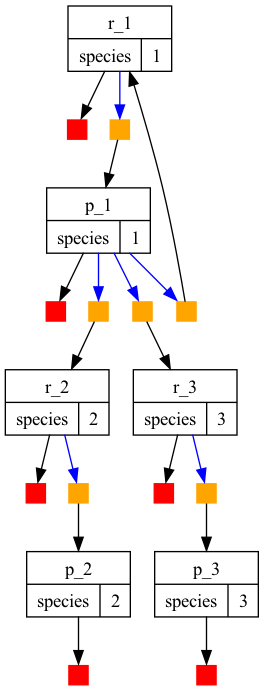

In [5]:
GraphicalModel.for_jupyter(chen_tm)

In [6]:
params = {
    'V': [0.03, 0.03, 0.03],
    'U': [0.15, 0.15, 0.015],
    'C': [0.03, 0.03, 0.024],
}
inits = {
    'r': [3, 6, 5],
    'p': [100, 500, 1],
}
for k, v in params.items():
    for idx, val in enumerate(v):
        chen_tm.parameters[f'{k}_{idx}'].value = val
for k, v in inits.items():
    for idx, val in enumerate(v):
        chen_tm.initials[f'{k}_{idx + 1}'].expression = SympyExprStr(sympy.Float(val))

In [7]:
om = OdeModel(Model(chen_tm), initialized=True)

In [8]:
ts = numpy.linspace(0, 10*60, 100)
res = simulate_ode_model(om, times=ts)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Proportion')

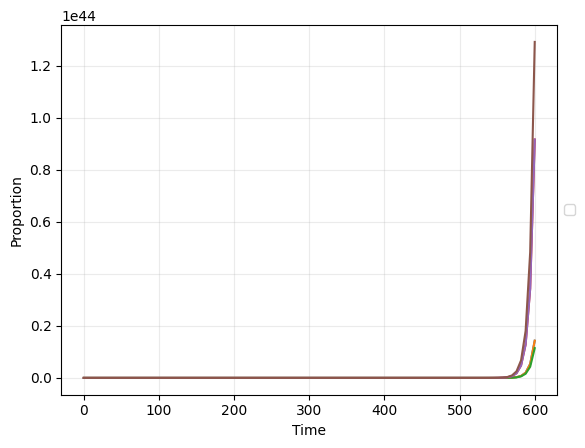

In [9]:
plt.plot(ts, res)#, label=range(1,7))
#plt.ylim([0, 1.25])
plt.grid(alpha=0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Proportion')

In [10]:
om.kinetics

Matrix([
[ -0.03*y[0, 0] + 0.03*y[3, 0]],
[ -0.03*y[1, 0] + 0.03*y[3, 0]],
[-0.03*y[2, 0] + 0.024*y[3, 0]],
[   2.0*y[0, 0] - 0.15*y[3, 0]],
[   2.0*y[1, 0] - 0.15*y[4, 0]],
[  2.0*y[2, 0] - 0.015*y[5, 0]]])

## Part 2: Hunt Model
For part 2, the Hunt Model, the original model from part 1 is extended and now includes more feedback loops. From the scenario 6 description:
> **Hunt Model:** In this scenario, we also consider an extended model of gene expression, proposed by [Hunt et. al.](https://www.public.asu.edu/~etcamach/AMSSI/reports/gene.pdf), which incorporates multiple additional feedback loops into the protein synthesis process:
> - Type 2 proteins help stabilize all mRNA against degradation (in effect lowers degradation rate)
> - Each type of protein regulates the production of its own protein type, during both transcription and translation processes

The extended model follows the following system of equations (copied from the scenario instructions and LaTeX-ified).

From the description:
> Where:
> - $r_i$ represent the concentration of Type $i$ mRNA, in units $nMolar$
> - $p_i$ represent the concentration of Type $i$ protein, in units $nMolar$
> - $C_i$ represents the transcription rates for Type $i$ mRNA, in units $\frac{\text{nMolar of mRNA}}{\text{nMolar of protein} \cdot \text{minute}}$
> - $L_i$ represents the translation rates for Type $i$ protein, in units $\frac{\text{nMolar of mRNA}}{\text{nMolar of protein} \cdot \text{minute}}$
> - $V_i$ is the natural degradation rate of Type $i$ mRNA, in units $\frac{1}{\text{minute}}$
> - $U_i$ is the natural degradation rate of Type $i$ protein, in units $\frac{1}{\text{minute}}$
> - $a_i$ is an effectiveness factor for feedback on transcription (i.e. suppresses the rate of transcription), for Type $i$ mRNA. The bigger the value of $a_i$, the smaller the impact of feedback and the less the transcription rate is decreased. The units are $nMolar$.
> - $d_i$ is an effectiveness factor for feedback on translation (i.e. suppresses the rate of translation), for Type $i$ proteins. The bigger the value of $d_i$, the smaller the impact of feedback and the less the translation rate is decreased. The units are $nMolar$.
> - $b_i$ is an effectiveness factor for feedback on mRNA degradation (i.e. Type 2 proteins act as stabilizers that lower the rate of degradation, for Type $i$ mRNA). The bigger the value of $b_i$, the smaller the impact of feedback and the less the degradation rate is decreased. The units are $nMolar$.


In [11]:
%%latex
\begin{align}
\frac{dr_1}{dt} & = \frac{1}{1 + \frac{p_1^2}{a_1^2}} C_1 p_1 - \frac{1}{1 + \frac{p_2}{b_1}} V_1 r_1 \\
\frac{dr_2}{dt} & = \frac{1}{1 + \frac{p_2}{a_2}} C_2 p_1 - \frac{1}{1 + \frac{p_2}{b_2}} V_2 r_2 \\
\frac{dr_3}{dt} & = \frac{1}{1 + \frac{p_3}{a_3}} C_3 p_1 - \frac{1}{1 + \frac{p_2}{b_3}} V_3 r_3 \\
\frac{dp_1}{dt} & = \frac{1}{1 + \frac{p_1}{d_1}} L_1 r_1 - U_1 p_1 \\
\frac{dp_2}{dt} & = \frac{1}{1 + \frac{p_2}{d_2}} L_2 r_2 - U_2 p_2 \\
\frac{dp_3}{dt} & = \frac{1}{1 + \frac{p_3}{d_3}} L_3 r_3 - U_3 p_3
\end{align}

<IPython.core.display.Latex object>

In [12]:
p = lambda i: Concept(name=f'p_{i}', context={'species': f'{i}'})
r = lambda i: Concept(name=f'r_{i}', context={'species': f'{i}'})
s = lambda x: sympy.Symbol(x)

templates = []
for i in range(1, 4):
    rprod = GroupedControlledProduction(controllers=[p(1), p(i)],
                                        outcome=r(i))
    rpart = 1 / (1 + (s(f'p_{i}') / s(f'a_{i-1}')) ** (2 if i == 1 else 1))
    rate = rpart * s(f'C_{i-1}')*s('p_1')
    rprod.rate_law = SympyExprStr(rate)
    templates.append(rprod)
    
    rdeg = ControlledDegradation(controller=p(2),
                                 subject=r(i))
    rpart = 1 / (1 + (s('p_2') / s(f'b_{i-1}')))
    rate = rpart * s(f'V_{i-1}')*s(f'r_{i}')
    rdeg.rate_law = SympyExprStr(rate)
    templates.append(rdeg)
    
    pprod = GroupedControlledProduction(controllers=[p(i), r(i)],
                                        outcome=p(i))
    rpart = 1 / (1 + (s(f'p_{i}') / s(f'd_{i-1}')))
    rate = rpart * s(f'L_{i-1}')*s(f'r_{i}')
    pprod.rate_law = SympyExprStr(rate)
    templates.append(pprod)    
    
    pdeg = NaturalDegradation(subject=p(i))
    pdeg.set_mass_action_rate_law(f'U_{i-1}')
    templates.append(pdeg)
for template in templates:
    print(template.rate_law)

C_0*p_1/(1 + p_1**2/a_0**2)
V_0*r_1/(1 + p_2/b_0)
L_0*r_1/(1 + p_1/d_0)
U_0*p_1
C_1*p_1/(1 + p_2/a_1)
V_1*r_2/(1 + p_2/b_1)
L_1*r_2/(1 + p_2/d_1)
U_1*p_2
C_2*p_1/(1 + p_3/a_2)
V_2*r_3/(1 + p_2/b_2)
L_2*r_3/(1 + p_3/d_2)
U_2*p_3


In [13]:
params.update({
    'L': [2, 2, 2],
    'a': [60, 140, 170],
    'b': [120, 140, 180],
    'd': [120, 150, 260],
})

In [14]:
hunt_tm = TemplateModel(
    templates=templates,
    initials=chen_tm.initials
)

for k, v in params.items():
    for idx, val in enumerate(v):
        pname = f'{k}_{idx}'
        if pname in hunt_tm:
            hunt_tm.parameters[pname].value = val
        else:
            hunt_tm.parameters[pname] = Parameter(name=pname, value=val)

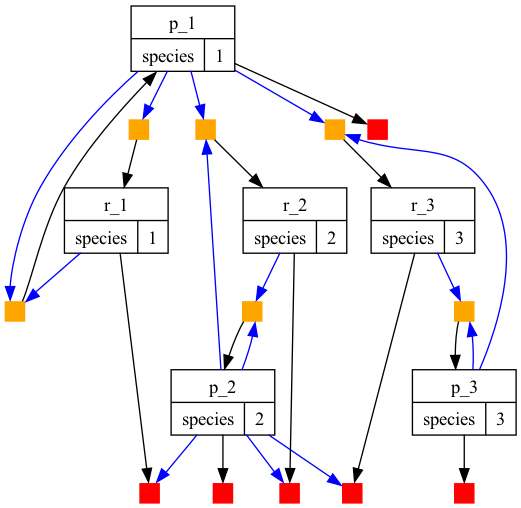

In [15]:
GraphicalModel.for_jupyter(hunt_tm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Proportion')

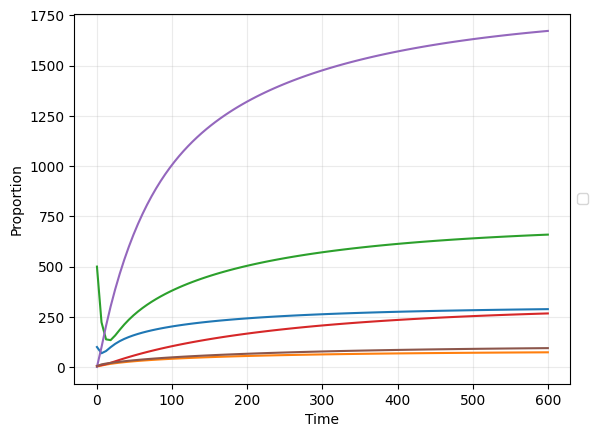

In [16]:
om = OdeModel(Model(hunt_tm), initialized=True)
ts = numpy.linspace(0, 10*60, 100)
res = simulate_ode_model(om, times=ts)
plt.plot(ts, res)#, label=range(1,7))
plt.grid(alpha=0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Proportion')

In [17]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}
models = {'chen': chen_tm, 'hunt': hunt_tm}

for mkey, model in models.items():
    for fkey, fun in frameworks.items():
        with open(f'scenario6_{mkey}_{fkey}.json', 'w') as fh:
            json.dump(fun(model), fh, indent=1)